## Obtain a discharge measurement over a cross section

Now that we have a suitable velocimetry result, we can extract river flows from it over user-provided cross sections. These must be provided in the same vertical reference as the water level was measured in, and they must eityher be in the same coordinate reference system (crs) as the ground control point observations used in the `CameraConfig` object, or in a crs that can be readily transformed into the crs of the camera projection. Below we first read the results back in memory

In [1]:
import xarray as xr
import pandas as pd
import pyorc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

First we read the masked results from notebook 03 back into memory. We also load the first frame of our original video in rgb format.


In [2]:
ds = xr.open_dataset("ngwerere/ngwerere_masked.nc")

# also open the original video file
video_file = "ngwerere/ngwerere_20191103.mp4"
video = pyorc.Video(video_file, start_frame=0, end_frame=1)

# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

# get the frame as rgb
da_rgb = video.get_frames(method="rgb")


We need a cross section. We have stored two cross sections in comma-separated text files (.csv) along with the examples. Below we load these in memory and we extract the x, y and z values from it. These are all measured in the same vertical reference as the water level. Let's first investigate if the cross sections are correctly referenced, by plotting them in the camera configuration.

In [3]:
cross_section = pd.read_csv("ngwerere/ngwerere_cross_section.csv")
x = cross_section["x"]
y = cross_section["y"]
z = cross_section["z"]
cross_section2 = pd.read_csv("ngwerere/ngwerere_cross_section_2.csv")
x2 = cross_section2["x"]
y2 = cross_section2["y"]
z2 = cross_section2["z"]

# let's have a look at the cross sections, the coordinates of the cross sections are in UTM 35S coordinates, 
# so we have to tell the axes that the coordinates need to be transformed from that crs into the crs of the axes.
# we also make a very very small buffer of 0.00005 degrees around the area of interest, so that we can 
# clearly see the cross sections.
ax = ds.velocimetry.camera_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"}, buffer=0.00005)
ax.plot(x, y, "g--", transform=ccrs.UTM(zone=35, southern_hemisphere=True), label="Cross section #1")
ax.plot(x2, y2, "y--", transform=ccrs.UTM(zone=35, southern_hemisphere=True), label="Cross section #2")
ax.legend()



The cross sections are clearly in the area of interest, this means we can sample velocities from them.
We use the x, y and z values, to get a transect of velocity values from the velocimetry results. The z-values are only used later, to fill in any missing velocities with a logarithmic profile. The `wdw` parameter is used to take the median of the velocity in a larger window. `wdw=1` is the default and means that a surrounding window of 3x3 is used to sample from. `wdw=0` means that only the pixel directly underneath the bathymetry point is used. To account for short duration variability in FPS or natural occurring velocities, we apply a little bit of smoothing in time on the results with a rolling mean over 4 time steps as a setting.

In [4]:
ds_points = ds.velocimetry.get_transect(x, y, z, crs=32735, rolling=4)
ds_points2 = ds.velocimetry.get_transect(x2, y2, z2, crs=32735, rolling=4)
ds_points

<xarray.Dataset>
Dimensions:       (points: 39, quantile: 5)
Coordinates: (12/13)
    xp            (points) float64 409.9 440.4 470.3 ... 1.237e+03 1.253e+03
    yp            (points) float64 276.6 285.7 294.5 303.1 ... 515.6 520.4 525.1
    xs            (points) float64 6.427e+05 6.427e+05 ... 6.427e+05 6.427e+05
    ys            (points) float64 8.304e+06 8.304e+06 ... 8.304e+06 8.304e+06
    lon           (points) float64 28.33 28.33 28.33 28.33 ... 28.33 28.33 28.33
    lat           (points) float64 -15.33 -15.33 -15.33 ... -15.33 -15.33 -15.33
    ...            ...
    y             (points) float64 6.555 6.426 6.296 6.167 ... 1.891 1.762 1.632
    xcoords       (points) float64 6.427e+05 6.427e+05 ... 6.427e+05 6.427e+05
    ycoords       (points) float64 8.304e+06 8.304e+06 ... 8.304e+06 8.304e+06
    scoords       (points) float64 0.0 0.13 0.26 0.39 ... 4.55 4.68 4.81 4.94
    zcoords       (points) float64 1.182e+03 1.182e+03 ... 1.183e+03 1.183e+03
  * quantile      (quantile) float64 0.05 0.25 0.5 0.75 0.95
Dimensions without coordinates: points
Data variables:
    v_x           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    v_y           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    s2n           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    corr          (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    cols          (points) float64 23.05 22.97 22.89 22.81 ... 20.09 20.01 19.93
    rows          (points) float64 11.57 12.57 13.57 14.56 ... 47.45 48.45 49.45
    v_dir         (points) float64 -4.631 -4.631 -4.63 ... -4.631 -4.631 -4.631
    v_eff_nofill  (quantile, points) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    camera_shape:   [1080, 1920]
    camera_config:  {\n    "height": 1080,\n    "width": 1920,\n    "crs": "P...
    h_a:            0.0

You can see that all coordinates and variables now only have a `quantile` and `points` dimension. The `point` dimension represents all bathymetry points. By default, quantiles [0.05, 0.25, 0.5, 0.75, 0.95] are derived, but this can also be modified with the `quantile` parameter. During the sampling, the bathymetry points are resampled to more or less match the resolution of the velocimetry results, in order to get a dense enough sampling. You can also impose a resampling distance using the `distance` parameter. If you would set this to 0.1, then a velocity will be sampled each 0.1 meters. Because our velocimetry grid has a 0.13 m resolution, the distance will by default be 0.13. The variables `v_eff_nofill` and `v_dir` are added, which is the effective velocity scalar, and its angle, perpendicular to the cross-section direction. `v_eff_nofill` at this stage may contain gaps because of unknown velocities in moments and locations where the mask methods did not provide satisfactory samples.

Using `.get_q`, missing velocities will be filled with a logarithmic profile fit, and depth integrated velocities [m2/s] computed. We apply this on both cross sections and then check out the results.

In [5]:
ds_points_q = ds_points.transect.get_q(fill_method="log_interp")
ds_points_q2 = ds_points2.transect.get_q(fill_method="log_interp")
ds_points_q

<xarray.Dataset>
Dimensions:       (points: 39, quantile: 5)
Coordinates: (12/13)
    xp            (points) float64 409.9 440.4 470.3 ... 1.237e+03 1.253e+03
    yp            (points) float64 276.6 285.7 294.5 303.1 ... 515.6 520.4 525.1
    xs            (points) float64 6.427e+05 6.427e+05 ... 6.427e+05 6.427e+05
    ys            (points) float64 8.304e+06 8.304e+06 ... 8.304e+06 8.304e+06
    lon           (points) float64 28.33 28.33 28.33 28.33 ... 28.33 28.33 28.33
    lat           (points) float64 -15.33 -15.33 -15.33 ... -15.33 -15.33 -15.33
    ...            ...
    y             (points) float64 6.555 6.426 6.296 6.167 ... 1.891 1.762 1.632
    xcoords       (points) float64 6.427e+05 6.427e+05 ... 6.427e+05 6.427e+05
    ycoords       (points) float64 8.304e+06 8.304e+06 ... 8.304e+06 8.304e+06
    scoords       (points) float64 0.0 0.13 0.26 0.39 ... 4.55 4.68 4.81 4.94
    zcoords       (points) float64 1.182e+03 1.182e+03 ... 1.183e+03 1.183e+03
  * quantile      (quantile) float64 0.05 0.25 0.5 0.75 0.95
Dimensions without coordinates: points
Data variables:
    v_x           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    v_y           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    s2n           (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    corr          (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    cols          (points) float64 23.05 22.97 22.89 22.81 ... 20.09 20.01 19.93
    rows          (points) float64 11.57 12.57 13.57 14.56 ... 47.45 48.45 49.45
    v_dir         (points) float64 -4.631 -4.631 -4.63 ... -4.631 -4.631 -4.631
    v_eff_nofill  (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    v_eff         (quantile, points) float64 0.0 0.03993 0.1018 ... 0.0 0.0 0.0
    q_nofill      (quantile, points) float64 nan nan nan nan ... nan nan nan nan
    q             (quantile, points) float64 0.0 0.002974 0.01396 ... 0.0 0.0
Attributes:
    camera_shape:   [1080, 1920]
    camera_config:  {\n    "height": 1080,\n    "width": 1920,\n    "crs": "P...
    h_a:            0.0

Now we have variables `v_eff` with velocities (filled with zeros where no data was found, but log profiles are also possible), and `q` and `q_nofill` which hold the depth integrated velocities. During depth integration the default assumption is that the depth average velocities is 0.9 times the surface velocity. This can be controlled by the `v_corr` parameter. Below, we make a quick plot of the `q` results for both profiles.

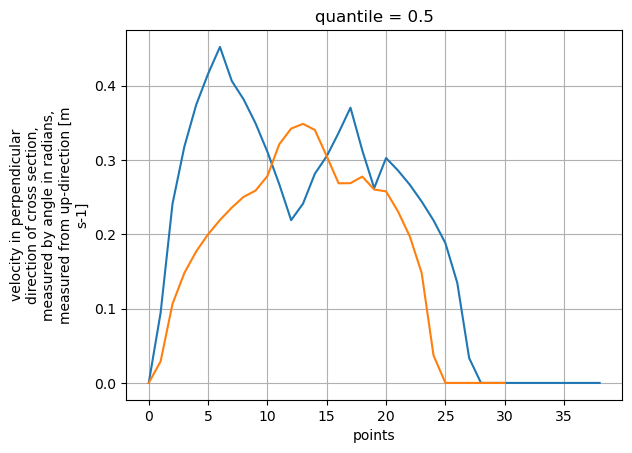

In [6]:
ax = plt.axes()
ds_points_q["v_eff"].isel(quantile=2).plot(ax=ax)
ds_points_q2["v_eff"].isel(quantile=2).plot(ax=ax)
plt.grid()

We can also plot the sampled surface velocities in combination with the velocity grid with bespoke plotting functions, giving intuitive graphics. We do this in the camera perspective below, similar to notebook 03.

In [7]:
# plot the rgb frame first. We use the "camera" mode to plot the camera perspective.
norm = Normalize(vmin=0., vmax=0.6, clip=False)

p = da_rgb[0].frames.plot(mode="camera")

# extract mean velocity and plot in camera projection
ds.mean(dim="time", keep_attrs=True).velocimetry.plot(
    ax=p.axes,
    mode="camera",
    cmap="rainbow",
    scale=200,
    width=0.001,
    alpha=0.3,
    norm=norm,
)

# plot velocimetry point results in camera projection
ds_points_q.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="camera",
    cmap="rainbow",
    scale=100,
    width=0.003,
    norm=norm,
)
ds_points_q2.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="camera",
    cmap="rainbow",
    scale=100,
    width=0.003,
    norm=norm,
    add_colorbar=True
)

# store figure in a JPEG
p.axes.figure.savefig("ngwerere.jpg", dpi=200)

Of course we can also plot our results in a local projection and add a selected plotting style to it. Below this is shown with a streamplot as example.

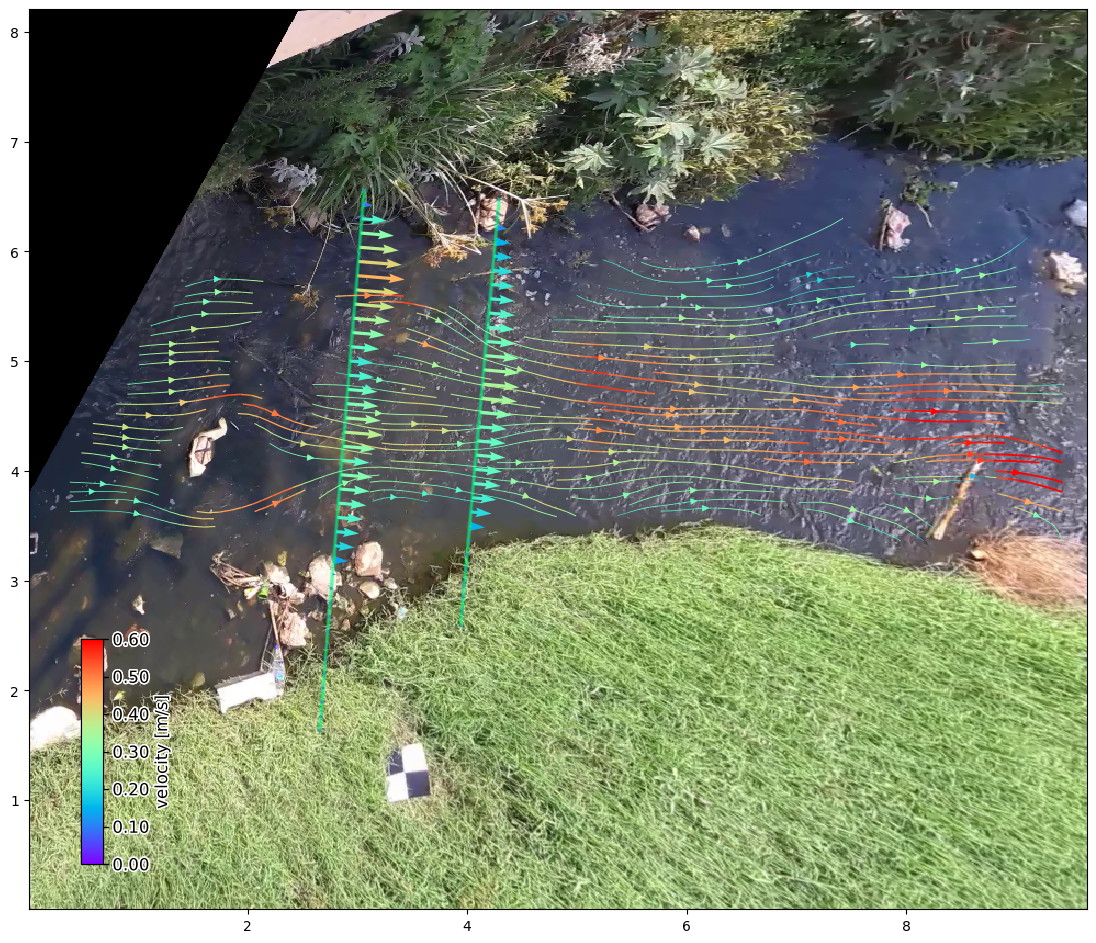

In [8]:
# again plot the projected background
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=0.6, clip=False)
ds_mean = ds.mean(dim="time", keep_attrs=True)
p = da_rgb.frames.project()[0].frames.plot(mode="local")

# plot velocimetry point results in local projection
ds_points_q.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="local",
    cmap="rainbow",
    scale=10,
    width=0.003,
    norm=norm,
    add_colorbar=True,
)

ds_points_q2.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="local",
    cmap="rainbow",
    scale=10,
    width=0.003,
    norm=norm,
    add_colorbar=True,
)
# to ensure streamplot understands the directions correctly, all values must 
# be flipped upside down and up-down velocities become down-up velocities.
ds_mean.velocimetry.plot.streamplot(
    ax=p.axes,
    mode="local",
    density=3.,
    minlength=0.05,
    linewidth_scale=2,
    cmap="rainbow",
    norm=norm,
    add_colorbar=True
)


Finally, we can extract discharge estimates from the cross section

In [9]:
ds_points_q.transect.get_river_flow()
print(ds_points_q["river_flow"])
ds_points_q2.transect.get_river_flow()
print(ds_points_q2["river_flow"])


<xarray.DataArray 'river_flow' (quantile: 5)>
array([0.09058056, 0.11943027, 0.15085924, 0.18429042, 0.21558698])
Coordinates:
  * quantile  (quantile) float64 0.05 0.25 0.5 0.75 0.95
Attributes:
    standard_name:  river_discharge
    long_name:      River Flow
    units:          m3 s-1
<xarray.DataArray 'river_flow' (quantile: 5)>
array([0.10600679, 0.13244257, 0.14760196, 0.16406498, 0.2041977 ])
Coordinates:
  * quantile  (quantile) float64 0.05 0.25 0.5 0.75 0.95
Attributes:
    standard_name:  river_discharge
    long_name:      River Flow
    units:          m3 s-1


You can see that the different quantiles give very diverse values, but that even with this very shallow and difficult example, the flow estimates are quite close to each other. The bathymetry was recorded at only 10 cm accuracy and the site is far from uniform, and so not ideal for cross-sectional discharge observations. This can easily explain the differences between two sampled cross sections. 

The diversity in quantile values can be because of many reasons and should be considered highly conservative. The real uncertainty is likely to be smaller in case velocities are well sampled. In case many velocities are filled in with interpolation, the uncertainty may also be larger. Reasons for variability are:

- the integration assumes that all velocity estimates for the same quantile, occur entirely correlated. This is naturally not the case in reality. Instead, water may vary slightly in its path from moment to moment and therefore the quantiles are a very conservative estimate. Especially during very low and shallow flows with lots of variability in direction and scalar values (such as in this example) this may lead to quite wide variability. 
- Frames-per-second of a video are not as constant as we would like them to be and many cameras (in particular cheap IP cameras) are not good at keeping track of the time evolution per frame. This can cause a lot of variability which has nothing to do with real uncertainty. `pyorc` does read frame-specific timings in case frame rates are not constant.
- last but not least, remaining uncertainties in the PIV solution can cause variability.
